In [3]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir


In [214]:
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}

AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]



In [2]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [4]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_from_summary('player_valuation', g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]), 
    resources_delta = (final_resources-initial_resources)[0]
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)

    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2"])

    return df


# Section One

## Trading

In [197]:
log_dir = "../experiments/section_one/.logs/trading_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

THERE ARE 471 log files
471 Loaded Successfully


In [216]:
df_copy = df.copy()
df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)

df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
df_copy['models'] = df_copy['models'].apply(lambda v: "@".join(sorted(v.split('@'))))

# swap cells which are re-ordered
to_swap = df_copy['model_1'] > df_copy['model_2'] 
temp = df_copy['resource_delta_1'][to_swap].copy()
df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
df_copy['resource_delta_2'][to_swap] = temp

df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
df_copy['win_2'] =df_copy['resource_delta_1'] < df_copy['resource_delta_2']
df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']

df_copy = df_copy.groupby(['game_name', 'models'])[[ 'win_1', 'win_2', 'resource_delta_1', 'resource_delta_2']].agg(['mean',]).reset_index()

df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
win_rates = df_copy["win_1"]["mean"].tolist() + df_copy["win_2"]["mean"].tolist()
payoffs = df_copy["resource_delta_1"]["mean"].tolist() + df_copy["resource_delta_2"]["mean"].tolist()
model1 = df_copy["model_1"].tolist() + df_copy["model_2"].tolist()
model2  = df_copy["model_2"].tolist() + df_copy["model_1"].tolist()

aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, "model_2" : model2})


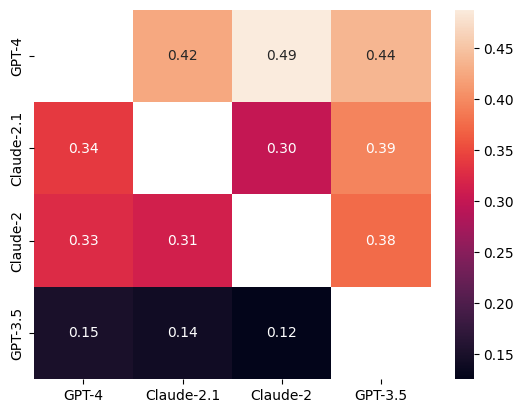

In [221]:
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="winrate")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_trading_winrate.pdf") 

### WinRate

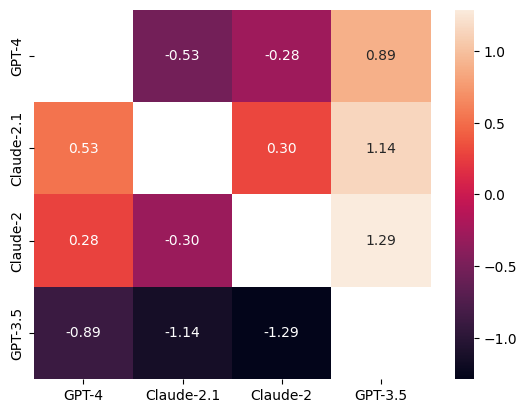

In [220]:
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_trading_winrate.pdf") 

### Payoff

In [166]:
df_copy.columns

MultiIndex([(       'game_name',     ''),
            (          'models',     ''),
            (           'win_1', 'mean'),
            (           'win_2', 'mean'),
            ('resource_delta_1', 'mean'),
            ('resource_delta_2', 'mean'),
            (         'model_1',     ''),
            (         'model_2',     '')],
           )

In [183]:
df_gg

,winrate,payoff,model_1,model_2
0,0.394366,1.140845,Claude-2.1,GPT-3.5
1,0.337500,0.525000,Claude-2.1,GPT-4
2,0.312500,-0.300000,Claude-2,Claude-2.1
3,0.375000,1.287500,Claude-2,GPT-3.5
4,0.325000,0.275000,Claude-2,GPT-4
5,0.150000,-0.887500,GPT-3.5,GPT-4
6,0.140845,-1.140845,GPT-3.5,GPT-3.5
7,0.425000,-0.525000,GPT-4,GPT-4
8,0.300000,0.300000,Claude-2.1,Claude-2.1
9,0.125000,-1.287500,GPT-3.5,GPT-3.5


model_2,Claude-2,Claude-2.1,GPT-3.5,GPT-4
model_1,,,,
Claude-2,NaN,-0.300000,1.287500,0.2750
Claude-2.1,0.3000,NaN,1.140845,0.5250
GPT-3.5,-1.2875,-1.140845,NaN,-0.8875
GPT-4,-0.2750,-0.525000,0.887500,NaN


In [187]:

aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, "model_2" : model2})
aggregated = aggregated.pivot(index="model_1", columns="model_2", values="payoff")


# aggregated = df_copy.groupby(["model_1", "model_2"])[['resource_delta_1', 'resource_delta_2']].mean().reset_index()
# aggregated["join"] = aggregated.apply(lambda x : join_names(x.model_1, x.model_2), axis=1)

#aggregated = aggregated.groupby(["join"])[['resource_delta_1', 'resource_delta_2']].mean().reset_index()
#aggregated[['model_1', 'model_2']] = aggregated['join'].str.split('#', n=1, expand=True)

#aggregated.pivot(index="model_1", columns="model_2", values="resource_delta_1")

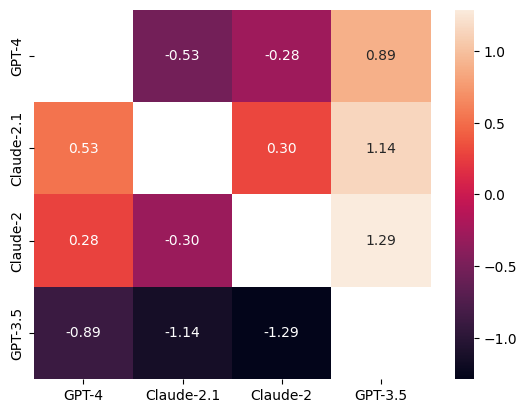

In [188]:
mask = np.eye(aggregated.values.shape[0], dtype=bool)
aggregated =aggregated.fillna(1)

aggregated = aggregated.reindex(index=AGENTS_CLEAN_NAMES, columns=AGENTS_CLEAN_NAMES)


g2 = sns.heatmap(aggregated, annot=True, mask=mask, fmt=".2f")
g2.set(ylabel=None)
g2.set(xlabel=None)

g2.get_figure().savefig("figures/section_one_trading_payoff.pdf") 


## Ultimatum

In [189]:
log_dir = "../experiments/section_one/.logs/ultimatum_multi_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)


THERE ARE 240 log files
240 Loaded Successfully


In [190]:
df["resource_delta_1"] = df["resource_delta_1"] + 100

### Win Rate

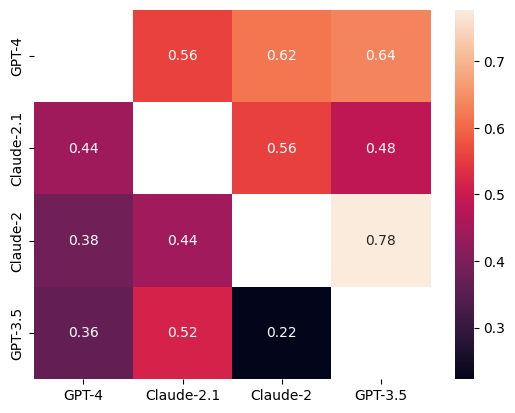

In [191]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
PAIRS_OF_AGENTS = [[x, y] for x, y in itertools.product(AGENTS, AGENTS) if x != y]

l2 = collect_and_plot_heatmap(df, AGENTS, AGENTS_CLEAN_NAMES, PAIRS_OF_AGENTS)
mask = np.eye(l2.shape[0], dtype=bool)

figu = sns.heatmap(l2, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)


In [192]:
fig = figu.get_figure()
fig.savefig("figures/section_one_ultimatum_winrate.pdf") 

### PayOff

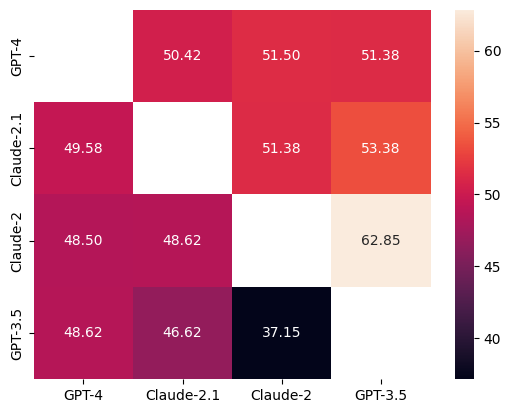

In [193]:
df_copy = df.copy()
df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)

df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
df_copy['models'] = df_copy['models'].apply(lambda v: "@".join(sorted(v.split('@'))))

# swap cells which are re-ordered
to_swap = df_copy['model_1'] > df_copy['model_2'] 
temp = df_copy['resource_delta_1'][to_swap].copy()
df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
df_copy['resource_delta_2'][to_swap] = temp

df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
df_copy['win_2'] =df_copy['resource_delta_1'] < df_copy['resource_delta_2']
df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']

df_copy = df_copy.groupby(['game_name', 'models'])[[ 'win_1', 'win_2', 'resource_delta_1', 'resource_delta_2']].agg(['mean',]).reset_index()

df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
win_rates = df_copy["win_1"]["mean"].tolist() + df_copy["win_2"]["mean"].tolist()
payoffs = df_copy["resource_delta_1"]["mean"].tolist() + df_copy["resource_delta_2"]["mean"].tolist()
model1 = df_copy["model_1"].tolist() + df_copy["model_2"].tolist()
model2  = df_copy["model_2"].tolist() + df_copy["model_1"].tolist()
aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, "model_2" : model2})
aggregated = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

mask = np.eye(aggregated.values.shape[0], dtype=bool)
aggregated =aggregated.fillna(1)

aggregated = aggregated.reindex(index=AGENTS_CLEAN_NAMES, columns=AGENTS_CLEAN_NAMES)


g2 = sns.heatmap(aggregated, annot=True, mask=mask, fmt=".2f")
g2.set(ylabel=None)
g2.set(xlabel=None)
g2.get_figure().savefig("figures/section_one_ultimatum_payoff.pdf") 
